In [14]:
#Environment Details
# !python --version
# !nvidia-smi
# !pip freeze

#Use when not running in Colab
# !pip install numpy==1.18.5
# !pip install tensorflow==2.3.0
# !pip install pandas==1.0.5
# !pip install seaborn==0.10.1
# !pip install matplotlib==3.2.2
# !pip install sklearn==0.0
# !pip install scipy==1.4.1

In [15]:
#Pre-requisites
!pip install gdown
# !pip install tensorflow==2.3.0

#Let’s download the data
# !gdown https://cdap-fmg.s3.us-east-2.amazonaws.com/WISDM_WATCH_ACCEL.txt
!gdown https://drive.google.com/uc?id=1bol4ADpBa5G7GJ3ilUxbAiRLKUh-qm4g

Downloading...
From: https://drive.google.com/uc?id=1bol4ADpBa5G7GJ3ilUxbAiRLKUh-qm4g
To: /content/WISDM_WATCH_ACCEL.txt
63.8MB [00:00, 154MB/s] 


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

Reading the Dataset:

In [17]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('WISDM_WATCH_ACCEL.txt', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

# removing the 'timestamp' column.
df.pop('timestamp')
df.head() #Outputs the first few lines of Data
#df.shape #Outputs number of rows and collumns

,user_id,activity,x_axis,y_axis,z_axis
0,1600,Walking,7.091625,-0.591667,8.195502
1,1600,Walking,4.972757,-0.158317,6.696732
2,1600,Walking,3.253720,-0.191835,6.107758
3,1600,Walking,2.801216,-0.155922,5.997625
4,1600,Walking,3.770868,-1.051354,7.731027


spliting the data into training and test datasets:

In [18]:
df_train = df[df['user_id'] <= 1640]
df_test = df[df['user_id'] > 1640]

In [19]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 400
STEP = 40

# X_train is the training data set. 
# y_train is the set of labels to all the data in x_train
# X_test,y_test - This part of the data does not participate in the training of the model, but is used to evaluate the quality of the trained model.

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

Converting Activity names to numbers:

In [20]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [21]:
# The model is defined as a Sequential Keras model.
# with a LSTM layer. 
# Which is followed by a dropout layer intended to reduce overfitting of the model to the training data. 
# A dense layer is used to interpret the features extracted by the LSTM layer, 
# Final output layer is used to make predictions.


model = keras.Sequential()
model.add(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
)
model.add(keras.layers.Dropout(rate=0.5))  # 0 < rate < 1
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [22]:
# one epoch = one forward pass and one backward pass of all the training examples
# batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
# number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_split=0.1,
    shuffle=False,
)

Epoch 1/300
307/307 [==============================] - 11s 30ms/step - loss: 1.3730 - acc: 0.4137 - val_loss: 1.7046 - val_acc: 0.5147
Epoch 2/300
307/307 [==============================] - 9s 29ms/step - loss: 1.1274 - acc: 0.5091 - val_loss: 0.9747 - val_acc: 0.5151
Epoch 3/300
307/307 [==============================] - 9s 29ms/step - loss: 0.9925 - acc: 0.5509 - val_loss: 1.1657 - val_acc: 0.5390
Epoch 4/300
307/307 [==============================] - 9s 29ms/step - loss: 1.0000 - acc: 0.5471 - val_loss: 1.1035 - val_acc: 0.7284
Epoch 5/300
307/307 [==============================] - 9s 29ms/step - loss: 0.9033 - acc: 0.5848 - val_loss: 0.8342 - val_acc: 0.6757
Epoch 6/300
307/307 [==============================] - 9s 29ms/step - loss: 0.8903 - acc: 0.6141 - val_loss: 1.5851 - val_acc: 0.7307
Epoch 7/300
307/307 [==============================] - 9s 29ms/step - loss: 0.8041 - acc: 0.6680 - val_loss: 1.0683 - val_acc: 0.7408
Epoch 8/300
307/307 [==============================] - 9s 29m

In [23]:
# See how well can it predict the test data, second number is accuracy percentage
model.evaluate(X_test, y_test)

142/142 [==============================] - 1s 10ms/step - loss: 0.3625 - acc: 0.9165


[0.36247479915618896, 0.9165375232696533]

Plotting the loss graph:

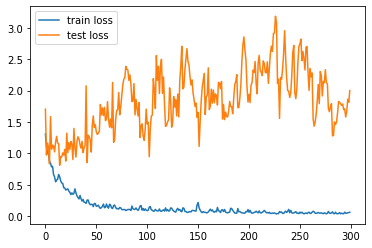

In [24]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

Plotting the Confusion Matrix:

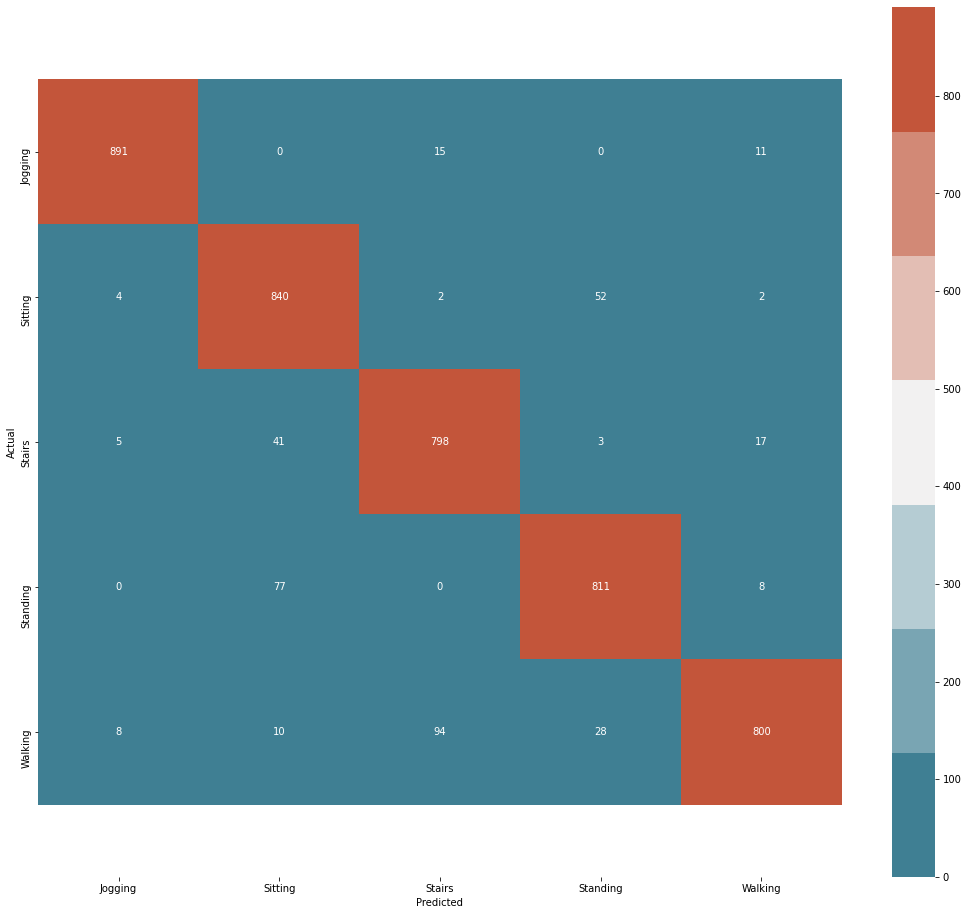

In [25]:
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

Creating the model h5 file:

In [26]:
# Exporting the model

model.save("lifestyle_model.h5")

#reloading saved model
new_model = tf.keras.models.load_model('lifestyle_model.h5')
new_model.summary()

print("\nmain model result ///////////////////////////////////////////////////////")
model.evaluate(X_test, y_test) # main model result

print("\nsaved and loaded model result ///////////////////////////////////////////////////////")
new_model.evaluate(X_test, y_test) # saved and loaded model result

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 84,741
Trainable params: 84,741
Non-trainable params: 0
_________________________________________________________________

main model result ///////////////////////////////////////////////////////
142/142 [==============================] - 1s 10ms/step - loss: 0.3625 - acc: 0.9165

saved and loaded model result ///////////////////////////////////////////////////////
1

[0.36247479915618896, 0.9165375232696533]